# Lesson 1  Linear Model with TensorFlow

by [Guy Tordjman-GitHub](https://github.com/Turgibot)

### About this lesson:
<p style="font-size:16px;">
prerequisites:<br>
To enjoy the most of this lesson one should be familiar with the python programming language, basic linear algebra like matrix multiplication, gradient descent and the jupyter notebook interface. 
Any knowledge of machine learning and classification is helpful but not required for the purpose of this lesson.
At the end of this lesson you'll be able to classify images of digits and more important you'll understand a basic tensorflow workflow.

## Why TensorFlow?
<p style="font-size:16px;">
    TensorFlow was originally created by researchers at Google as a single infrastructure for machine learning in both production and research. On the Tensorflow website, we see:<br><br>
   “TensorFlow™ is an open source software library for
    numerical computation using data flow graphs.”<br><br>
    TensorFlow is both flexible and scalable, allowing users to streamline from research into production.
<br>
This unique position allowed TensorFlow to grow quickly. It’s currently being used by big companies such as Google, OpenAI, NVIDIA, Intel, SAP, eBay, Airbus, Uber, Airbnb, Snap, Dropbox and startups alike. By the number of stars and related repositories on GitHub as of Jan 11, 2018, TensorFlow is by far the most popular machine learning library with more than 85.4k stars and 25.3k related repositories, twice as much as the total stars and related repositories of Caffe, PyTorch, Torch, and Theano combined. 
<br>
In summary, we chose TensorFlow because:

<ul style="font-size:16px;">
    <li>Python API</li>
<li>Portability: deploy computation to one or more CPUs or GPUs in a desktop, server, or mobile device with a single API</li>
<li>Flexibility: from Raspberry Pi, Android, Windows, iOS, Linux to server farms</li>
<li>Visualization (Lesson >=3 using 'TensorBoard')</li>
<li>Save and restore models, graphs</li>
<li>Auto-differentiation autodiff</li>
<li>Large community (~300k commits, ~85k repositories)</li>


# Code

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

Instructions for updating:
Use the retry module or similar alternatives.


### TF version should be bigger than 1.4

In [2]:
tf.__version__

'1.7.0'

## Getting the data 
<p style="font-size:16px;">
Downloading the 12MB data-set to a specific path 
    

In [3]:
import mnist
train_images = mnist.train_images()
train_labels = mnist.train_labels()
test_images = mnist.test_images()
test_labels = mnist.test_labels()
eval_images = train_images[:5000]
eval_labels = train_labels[:5000]
train_images = train_images[5000:]
train_labels = train_labels[5000:]

Get the size of the data set

In [4]:
train_len = len(train_labels)
test_len = len(test_labels)
eval_len = len(eval_labels)
print('Training-set:\t{}'.format(train_len))
print('Test-set:\t{}'.format(test_len))
print('Evaluation-set:\t{}'.format(eval_len))

Training-set:	55000
Test-set:	10000
Evaluation-set:	5000


Lets arrange the data in a dictionary data structure

## Set One Hot Encoding
<p style="font-size:16px;">
    Our labels are simply the number which is represented in the image. <br>Here are the first 5 labels:

In [5]:
test_labels[0:5]

array([7, 2, 1, 0, 4], dtype=uint8)

<p style="font-size:16px;"> In one hot representation the number represents the index which value is 1 where the rest are 0's.
We are classifying 10 digits (0 - 9), therefor a vector og length=10 is needed to represent each label.
For example the label where the digit is 7 is represented by: '[0,0,0,0,0,0,0,1,0,0]'.
Lets create a function that converts to one hot.</p>

In [6]:
def convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=(len(vector), num_classes))
    result[np.arange(len(vector)), vector] = 1
    return result.astype(int)

In [7]:
num_classes = 10
test_labels_oh = convert_to_one_hot(test_labels, num_classes)
train_labels_oh = convert_to_one_hot(train_labels, num_classes)
eval_labels_oh = convert_to_one_hot(eval_labels, num_classes)

In [8]:
test_labels_oh[0:5]

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

Note that we converted all the labels in our data set to one hot.<br>
Now, lets organize it in a dictionary data structure
Before we should flatten the 28 * 28 images to a 1 dimention 784 long vector 

In [9]:
class Input:
    
    def __init__(self, images, labels, classes):
        self.data_set_size = len(labels)
        self.images = images
        self.labels = labels
        self.classes = classes
        self.processed = 0
        self.epoc_done = False
    
    def next_batch(self,batch_size):
        start = self.processed
        end = start+batch_size
        if end >= self.data_set_size:
            end = self.data_set_size-1
            self.epoc_done = True
        self.processed = end
        img_batch = self.images[start:end]
        label_batch = self.labels[start:end]
        classes_batch = self.classes[start:end]
        
        if self.epoc_done is True:
            self.processed = 0
            self.epoc_done = False
        
        return (img_batch, label_batch, classes_batch)
            
        
    
class Data:
    #reshape the images
    train_images_rs = np.reshape(train_images, (55000, 784))
    test_images_rs =  np.reshape(test_images, (10000, 784))
    eval_images_rs = np.reshape(eval_images, (5000, 784))
    
    train = Input(train_images_rs,train_labels_oh,train_labels)
    test = Input(test_images_rs,test_labels_oh,test_labels)
    evaluation = Input(eval_images_rs,eval_labels_oh,eval_labels)

data = Data()

## Get The Image Data
<p style="font-size:16px;">
    For future calculations we would need to know the dimentions of the image we work with.<br>
    our list contains of 10000 images and each it a 3d matrix (2d - in black n white images like MNIST) 

In [10]:
single_image = train_images[0]
img_shape = single_image.shape
image_flat_size = img_shape[0]*img_shape[1]
print('The image shape is: {}'.format(img_shape))

The image shape is: (28, 28)


## Plot the Images
<p style="font-size:16px;">
    Create a helper function that display a 4X8 grid of images with the classification results noted

In [11]:
def plot_images_grid(images, img_shape, given_class, predicted_class=None):
    assert len(images) == 32
    assert len(given_class) == 32
    
    fig, axes = plt.subplots(4, 8)
    fig.subplots_adjust(hspace=0.5, wspace=0.05, left=0, right=2.3)

    for i, ax in enumerate(axes.flat):
        # Plot each image
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show given and predicted classes if exists.
        if predicted_class is None:
            xlabel = "Class: {0}".format(given_class[i])
            ax.set_xlabel(xlabel)
                
        else:
            xlabel = "Class: {0}, Predicted: {1}".format(given_class[i], predicted_class[i])
            if given_class[i] == predicted_class[i]:
                ax.set_xlabel(xlabel, color='green')
            else:
                ax.set_xlabel(xlabel)
                ax.set_xlabel(xlabel, color='red')
                

        
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

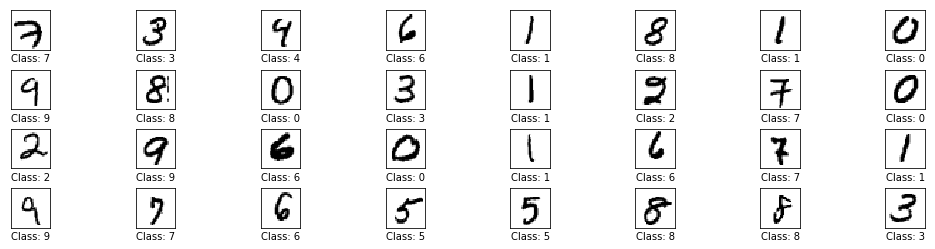

In [12]:
sample_images = data.train.images[0:32]
classes = data.train.classes[0:32]
plot_images_grid(sample_images, img_shape, classes)

# TF.Graph
<p style="font-size:16px;">
    A graph consists of nodes and edges that represent the computation procedure. To simplify things for now we'll agree that Tensor flow uses a computational graph that is executed much more efficiently than if the same calculations were to be performed directly in Python. <br>
   Next, we shell construct the graph and explain in details about each part below:

## Place Holder Variable
<p style="font-size:16px;">
    A placeholder is a type of variable which purpose is exactly as it's name suggests - to hold a place for an input. One can look at it as a promise of the developer to feed data into this the graph when time comes.

In [13]:
x = tf.placeholder(tf.float32, [None, image_flat_size])
y_given = tf.placeholder(tf.float32, [None, num_classes])
y_given_class = tf.placeholder(tf.int64, [None])

<p style="font-size:16px;">
    When printed we can see information about the placeholder:

In [14]:
x

<tf.Tensor 'Placeholder:0' shape=(?, 784) dtype=float32>

In [15]:
y_given

<tf.Tensor 'Placeholder_1:0' shape=(?, 10) dtype=float32>

In [16]:
y_given_class

<tf.Tensor 'Placeholder_2:0' shape=(?,) dtype=int64>

<p style="font-size:16px;">
    <strong>x</strong> is the placeholder variable for the input images. It is a tensor which means a multi-dimensional vector or matrix.  The data-type is set to float32 and the shape is set to [None, image_flat_size], where None means that the tensor may hold any number of images with each image being a vector of length image_flat_size(28*28=784 in our case).

<p style="font-size:16px;">
    <strong>y_given</strong> is the placeholder variable for the given labels of the input images in the placeholder variable x. The shape of this placeholder variable is [None, num_classes] which means it may hold any number of labels and each label is a vector of length num_classes (10).

<p style="font-size:16px;">
    <strong>y_given_class</strong> is the placeholder variable for the actual class of each image in the placeholder variable x. These are integers and the dimensionality of this placeholder variable is set to [None] which means the placeholder variable is a one-dimensional vector of any length.

# Tf.Varable - Weights and Biases
<p style="font-size:16px;">
As mentioned - the purpose of placeholder are to feed input data into the graph. Other than input and output there are other variables that need to be calculated and changed and optimized when running the program. These are called tf.Variables. <br>
    TensorFlow recommends that we use the wrapper tf.get_variable, which allows for easy variable sharing. With tf.get_variable, we can provide variable’s internal name, shape, type, and initializer to give the variable its initial value.
    <br><br>
    tf.get_variable(<br>
    name,<br>
    shape=None,<br>
    dtype=None,<br>
    initializer=None,<br>
    regularizer=None,<br>
    trainable=True,<br>
    collections=None,<br>
    caching_device=None,<br>
    partitioner=None,<br>
    validate_shape=True,<br>
    use_resource=None,<br>
    custom_getter=None,<br>
    constraint=None<br>
)<br>
<br>

In [17]:
weights = tf.get_variable('weights', initializer=tf.zeros([image_flat_size, num_classes]))
biases = tf.get_variable('biases', initializer=tf.zeros([num_classes]))

<p style="font-size:16px;">
    <strong>weights</strong> is a TensorFlow variable and is initialized with zeros. It's shape is [image_flat_size, num_classes], a 2-dimensional matrix with 784 (image_flat_size) rows and 10 (num_classes) columns.<br><br>
    We can see this info by priniting it in browser:

In [18]:
weights

<tf.Variable 'weights:0' shape=(784, 10) dtype=float32_ref>

<p style="font-size:16px;">
    <strong>biases</strong> is a vector of length num_classes
    We can also see this info by priniting it in browser:

In [19]:
biases

<tf.Variable 'biases:0' shape=(10,) dtype=float32_ref>

# Mathematical Model
<p style="font-size:16px;">
    Now that we have our placeholders (for input) and our variables defined we can do something with them - we can build a model.
   This is the first lesson so the model is very basic.<br>
    It multiplies the images in the placeholder variable x with the weights and then adds the biases.
    It then stores the the result in a matrix typically named logits:  


In [20]:
y_logits = tf.matmul(x, weights) + biases

<p style="font-size:16px;">
x has a shape of( train_len, image_flat_size) -> (5500, 784)<br>
weights has a shape of (image_flat_size, num_classes) -> (784, 10)<br>
so the result is of shape (train_len, num_classes) -> (5500, 10) <br>
    That means that each image of the 5500 links to a vector with 10 posibilities...
    <br>
    Remember the promise we made? we should store the result in the "y_predicted" placeholder.
    but before lets normalize the results so each vector of 10 options will sum to 1 so each element's value is limited between 0 and 1. For that we use the softmax function. We will learn in more details about this function in a future lesson. 

In [21]:
y_predicted = tf.nn.softmax(y_logits)

<p style="font-size:16px;">
The neuron that has the maximum value is the predicted class:

In [22]:
y_predicted_class = tf.argmax(y_predicted, axis=1)

# The Cost Function and Optimization
<p style="font-size:16px;">
Chances are that when we try to classify an image using the existing weights and biases - we'll get a wrong result. We all learn by making mistakes and correct our doing so why shouldn't our program learn from it's mistakes and improve by correct itself?<br>
First we've got to see how wrong we are, and for that we have a cost function.
    
## The cost function
<p style="font-size:16px;">
The cost function is a function that mainly answers the question: "How far are we from the truthful value?"
There is a number of cost functions that one can use and some work better than other on certain models. I'll cover other cost function in future lesson. 
Because this is an introductory lesson I'll not go deep into the math of the cost function that we'll use. Understanding the higher level should suffice for the time being.<br>

### The Cross Entropy
<p style="font-size:16px;">
A desired cost function should return a zero if we got the right class - if we got it wrong we want a scaled value that will tell us how wrong we are - how exponentially wrong we are might work?<br>
The cross-entropy does it for us. It is always positive and continuous and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero.<br>

### Optimize it!!
<p style="font-size:16px;">
AS mentioned cost = 0 tells us that we are classifying the images correctly. Therefor one should seek to minimize the cross-entropy by changing the weights and biases of the model - this is called optimization.
TensorFlow has a built-in function for calculating the cross-entropy. Note that it uses the values of the logits because it also calculates the softmax internally.



In [23]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_logits,
                                                        labels=y_given)

<p style="font-size:16px;">
The cross entropy is a vector with the same shape of the input. We need a scalar number that represents the cost of intire model. So we'll simply average it:

In [24]:
cost = tf.reduce_mean(cross_entropy)

In [25]:
cost

<tf.Tensor 'Mean:0' shape=() dtype=float32>


## Optimizer
<p style="font-size:16px;">
Lets define our optimizer. We are actually adding another node to the graph telling it to minimize the cost by using a certain method for optimization. In our case it is the basic form of Gradient Descent where the step-size is set to 0.5.

In [26]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)

# How close are we?
<p style="font-size:16px;">
We need to measure our progress.<br>
The cost function tells us how far we are from perfectness. But we would like to know exactly how acurate our model is?
    to find out if we are correct or not for each image we can simply run this code:

In [27]:
correctness = tf.equal(y_predicted_class , y_given_class)

In [28]:
correctness = tf.cast(correctness, tf.float32)

<p style="font-size:16px;">
Basically its a long vector where each correct label is represented by 1 and a wrong one by 0 
    
## Accuracy
<p style="font-size:16px;">
    is the average of our correctness vector. Note that casting to float was neccessary.


In [29]:
accuracy = tf.reduce_mean(correctness)

# Run It!!
So far we did not calculate anything , we just constructed the graph, preparing it for later execution.
To do so we have to create a TensorFlow session.

## tf.Session()


In [30]:
session = tf.Session()

<p style="font-size:16px;">
Remember to initialize all our variables. Thats why we defined a type of initializer when we created them.
Any action that we want to conduct in the graph must be stated inside of a session.run() function.
    

In [31]:
session.run(tf.global_variables_initializer())

## batching
<p style="font-size:16px;">
Calculating the changes in the weights and biases after every image is very source consuming and slow. Instead with TF we can use Stochastic Gradient Descent which only uses a batch of images in each iteration of the optimizer. 

In [32]:
batch_size = 100

<p style="font-size:16px;">
Lets create a function for optimizing our training model. 
first lets get familiar with a new term: "epoch" .One epoch consists of one full training cycle on the training set. Once every sample in the set is seen, you start again - marking the beginning of the 2nd epoch. 
It takes in as parameters the number of epochs and the batch size:
Remember: there are many batches in a single epoch

In [33]:
def optimize_by_batch(num_iterations, batch_size):
    for i in range(num_iterations):
        # get the next batch of images and labels
        x_image_batch, y_given_batch, y_given_class = data.train.next_batch(batch_size)
        
        # create a dictionary of the placeholders.
        feed_dict_train = {x: x_image_batch,
                           y_given: y_given_batch}

        # Run the optimizer 
        session.run(optimizer, feed_dict=feed_dict_train)
        print('batch {0} / {1}'.format(i+1, num_iterations))

In [34]:
def optimize_by_epochs(num_epochs, batch_size):
    data.train.processed = 0
    batch_num = int(data.train.data_set_size / batch_size)
    for i in range(num_epochs):
        for j in range(batch_num):
            # get the next batch of images and labels
            x_image_batch, y_given_batch, y_given_class = data.train.next_batch(batch_size)

            # create a dictionary of the placeholders.
            feed_dict_train = {x: x_image_batch,
                               y_given: y_given_batch}

            # Run the optimizer 
            session.run(optimizer, feed_dict=feed_dict_train)
        print('epoch {0} / {1}'.format(i+1, num_epochs))        

<p style="font-size:16px;">
Create a feed dictionary to hold all the test dataset input:

In [35]:
feed_dict_test = {x:data.test.images,
                  y_given: data.test.labels,
                  y_given_class: data.test.classes}

 <p style="font-size:16px;">
Create a function to Get the Accracy value and print it to screen. 

In [36]:
def calculate_and_print_accuracy():
    session_accuracy = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(session_accuracy))

In [37]:
calculate_and_print_accuracy()

Accuracy on test-set: 9.8%


 <p style="font-size:16px;">
As you can see before training the model our chances to predict the image class is less than 10%.
lets plot it:

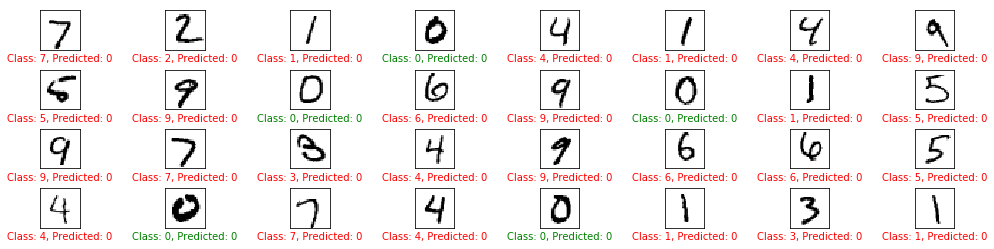

In [38]:
sample_images = data.test.images[0:32]
classes = data.test.classes[0:32]
classes_pred = session.run(y_predicted_class, feed_dict=feed_dict_test)
plot_images_grid(sample_images, img_shape, classes, classes_pred[0:32])

In [39]:
optimize_by_batch(num_iterations=3, batch_size=batch_size)

batch 1 / 3
batch 2 / 3
batch 3 / 3


<p style="font-size:16px;">
This are the results after 3 iterations:

In [40]:
calculate_and_print_accuracy()

Accuracy on test-set: 33.2%


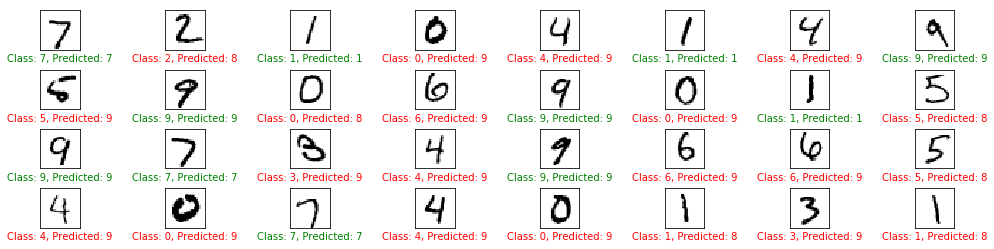

In [41]:

classes_pred = session.run(y_predicted_class, feed_dict=feed_dict_test)
plot_images_grid(sample_images, img_shape, classes, classes_pred[0:32])

<p style="font-size:16px;">
    After a very short training our weights and biases got tuned to classify a few images. Amazing don't you think? <br>
    How does the weight look like? lets create a function to plot some weights and run it: 
    

In [42]:
def plot_weights():
    # Get the weights.
    w = session.run(weights)
    
    # Get the min and max values 
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(2, 5)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        if i<10:
            image = w[:, i].reshape(img_shape)
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

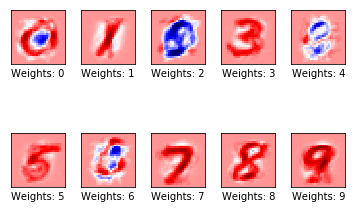

In [43]:
plot_weights()

In [44]:
print('number of processed images is {}'.format(data.train.processed))


number of processed images is 300


In [63]:
optimize_by_epochs(num_epochs=5, batch_size=batch_size)

epoch 1 / 5
epoch 2 / 5
epoch 3 / 5
epoch 4 / 5
epoch 5 / 5


In [64]:
calculate_and_print_accuracy()

Accuracy on test-set: 88.2%


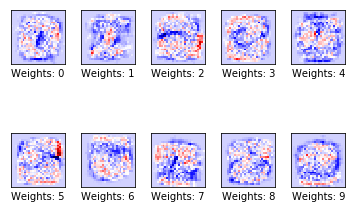

In [65]:
plot_weights()

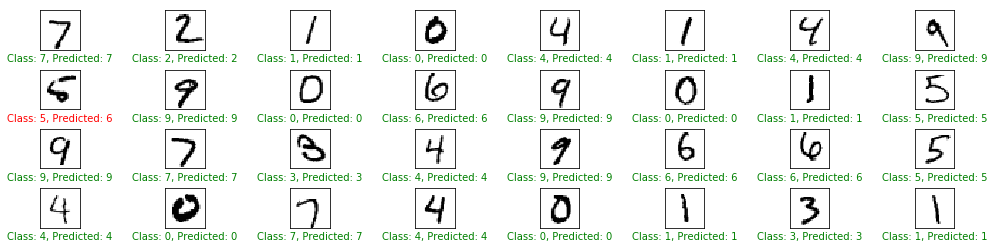

In [66]:
correct, classes_pred = session.run([correctness, y_predicted_class], feed_dict=feed_dict_test)
plot_images_grid(sample_images, img_shape, classes, classes_pred[0:32])

<p style="font-size:16px;">
We've completed our first mission and got a clssifier with an accuracy percentage of more than 85% with a basic linear classifier. Think about twicks and changes to the code that can improve this accuracy. We've learned alot - good job. Time for the second lesson now....

## License (MIT)

Copyright (c) 2018 by [Guy Tordjman](https://github.com/Turgibot)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.